## Анализ характера использования приложения для групп привлечения пользователей

In [33]:
import pandas as pd

import pandahouse as ph

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

import os
from dotenv import load_dotenv

In [34]:
load_dotenv()
# Подключение к базе
connection = {
    'host': os.getenv('HOST'),
    'password': os.getenv('PASSWORD'),
    'user': os.getenv('USER')
}

### Retention

In [35]:
# Выгружаем данные

q = """
SELECT
    toString(date) AS date,
    toString(start_date) AS start_date,
    COUNT(user_id) AS active_users, -- считаем юзеров
    source
FROM 
    (SELECT
        user_id,
        min(toDate(time)) AS start_date,
        source
    FROM 
        simulator_20240420.feed_actions 
    GROUP BY user_id, source
    HAVING start_date >= today() - 20
    ) t1 --точка входа

JOIN

    (SELECT 
        DISTINCT user_id,
        toDate(time) AS date
    FROM simulator_20240420.feed_actions) t2 --активность юзеров по дням

USING user_id

GROUP BY date, start_date, source
"""
# Выгружаем данные в датафрейм
df = ph.read_clickhouse(q, connection=connection)

In [36]:
df.head()

,date,start_date,active_users,source
0,2024-04-12,2024-04-07,382,organic
1,2024-04-20,2024-04-11,166,organic
2,2024-04-20,2024-04-10,148,ads
3,2024-04-21,2024-04-17,508,organic
4,2024-04-04,2024-04-04,374,ads


In [37]:
# Переведем даты в корректный формат
df['date'] = pd.to_datetime(df['date'])
df['start_date'] = pd.to_datetime(df['start_date'])

In [38]:
# Создадим индексы для когорт
df['cohort_idx'] = df.date.dt.day - df.start_date.dt.day

In [39]:
df['start_date'] = df['start_date'].dt.strftime('%d-%m-%Y')

In [40]:
# выводим в таблицу абсолютные значения количества пользователей для organic
organic_table = df.query('source == "organic"') \
    .pivot(index='start_date', columns='cohort_idx', values='active_users')
# Определяем размер каждой когорты
organic_cs = organic_table.iloc[:, 0]
# Считаем Retention Rate
organic_retention = organic_table.divide(organic_cs, axis=0)

In [41]:
# выводим в таблицу абсолютные значения количества пользователей для ads
ads_table = df.query('source == "ads"') \
    .pivot(index='start_date', columns='cohort_idx', values='active_users')
# Определяем размер каждой когорты
ads_cs = ads_table.iloc[:, 0]
# Считаем Retention Rate
ads_retention = ads_table.divide(ads_cs, axis=0)

In [42]:
# Heatmap для визуализации Retention
def retention_pivot_style(retention_table, cogort_size, source):
    fig, ax = plt.subplots(1, 2, figsize=(12, 8), sharey=True,
                       gridspec_kw={'width_ratios': [1, 11]})
    sns.heatmap(retention_table,
                mask=retention_table.isnull(),
                annot=True,
                fmt='.1%',
                cmap='RdYlGn',
                annot_kws={"size": 8},
                center=0.5,
                vmin=0,
                vmax=1,
                ax=ax[1])
    
    ax[1].set_title(f'Dayly Retention for {source}', fontsize=16)
    ax[1].set(xlabel='№ of periods', ylabel='')
    cohort_size_df = pd.DataFrame(cogort_size).rename(columns={0: 'cohort size'})
    white_cmap = mcolors.ListedColormap(['white'])
    sns.heatmap(cohort_size_df,
                annot=True,
                cbar=False,
                fmt='g',
                cmap=white_cmap,
                ax=ax[0])
    fig.tight_layout()

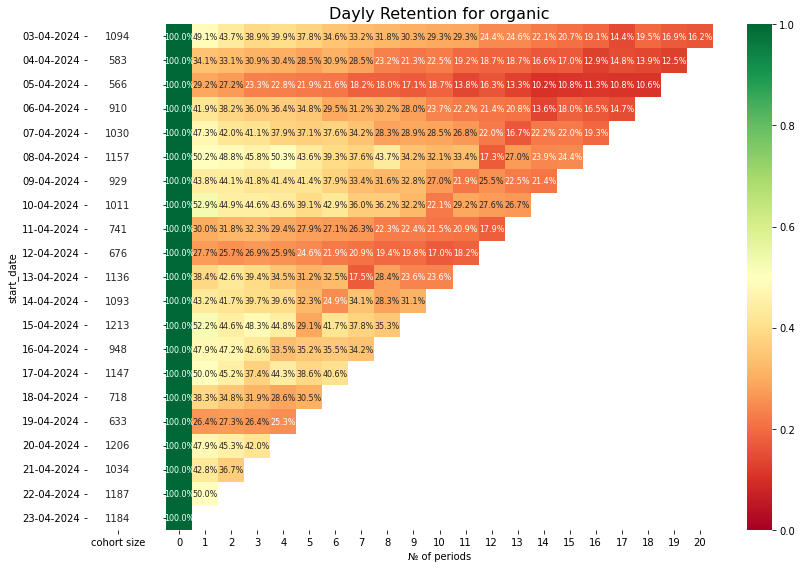

In [43]:
# Визуализируем retention для пользователей organic
retention_pivot_style(organic_retention, organic_cs, 'organic')

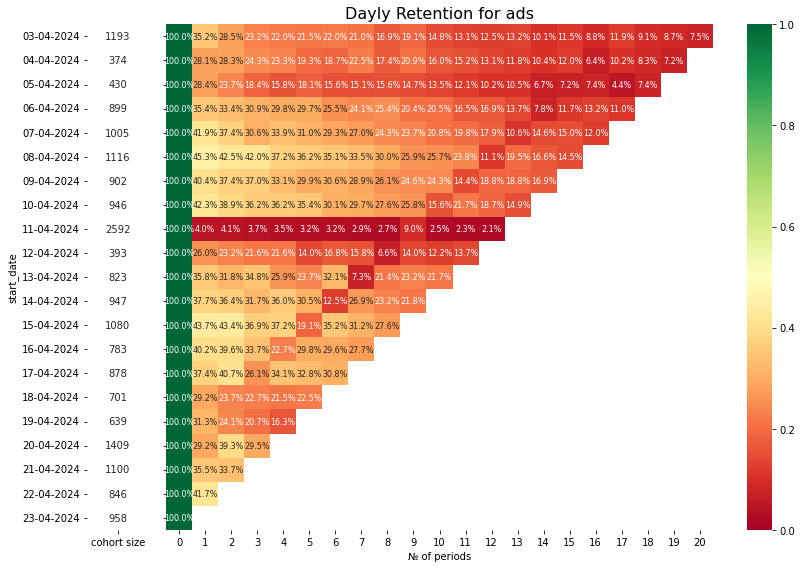

In [44]:
# Визуализируем retention для пользователей
retention_pivot_style(ads_retention, ads_cs, 'ads')

Визуализируем Retention 1-, 5-, 7-, 11-дня для обеих групп пользователей

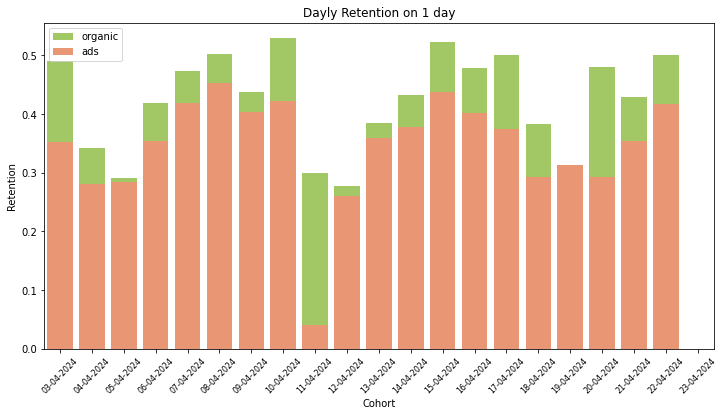

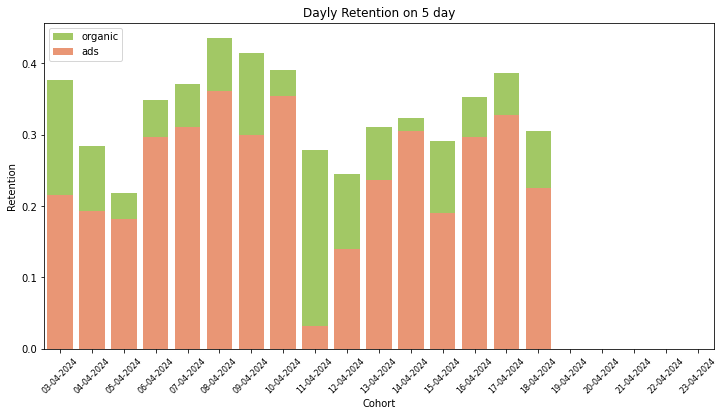

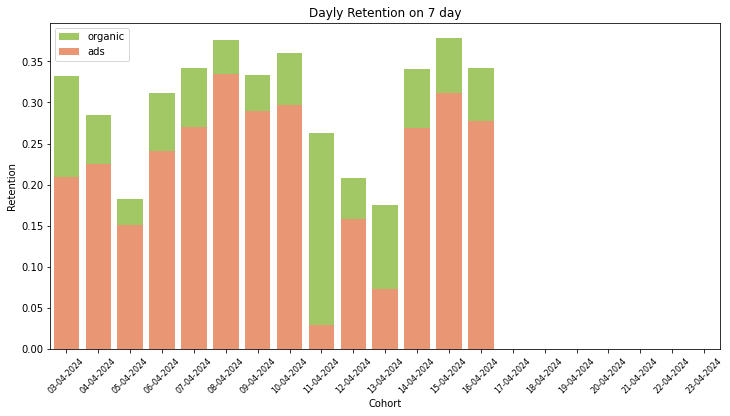

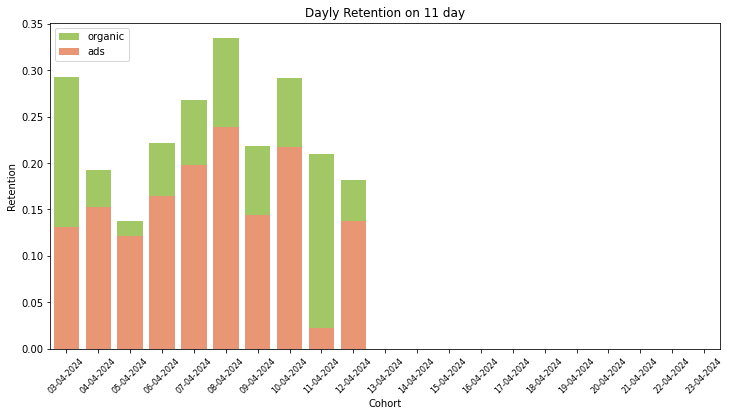

In [45]:
for i in (1, 5, 7, 11):
    plt.figure(figsize=(12,6))
    sns.barplot(data = organic_retention, 
                x=organic_retention.index, 
                y=organic_retention.iloc[:,i],
                color='#a6d854',
                label='organic')
    sns.barplot(data = ads_retention, 
                x=ads_retention.index, 
                y=ads_retention.iloc[:,i], 
                color='#fc8d62',
                label='ads')
    plt.xticks(rotation=45, fontsize=8)
    plt.title(f'Dayly Retention on {i} day')
    plt.xlabel('Cohort')
    plt.ylabel('Retention')
    plt.legend()


In [46]:
# Посчитаем разницу в размерах когорт
organic_df = organic_cs.to_frame().reset_index().rename(columns={0: 'organic'})
ads_df = ads_cs.to_frame().reset_index().rename(columns={0: 'ads'})
full_df = organic_df.merge(ads_df)
full_df['diff'] = full_df.organic - full_df.ads
full_df

,start_date,organic,ads,diff
0,03-04-2024,1094.0,1193.0,-99.0
1,04-04-2024,583.0,374.0,209.0
2,05-04-2024,566.0,430.0,136.0
3,06-04-2024,910.0,899.0,11.0
4,07-04-2024,1030.0,1005.0,25.0
5,08-04-2024,1157.0,1116.0,41.0
6,09-04-2024,929.0,902.0,27.0
7,10-04-2024,1011.0,946.0,65.0
8,11-04-2024,741.0,2592.0,-1851.0
9,12-04-2024,676.0,393.0,283.0


In [47]:
full_df.organic.sum(), full_df.ads.sum()

(20196.0, 20014.0)

### CTR

In [48]:
# Выгружаем данные

q = """
SELECT 
    toStartOfDay(time) AS day,
    source,
    countIf(user_id, action = 'like') / countIf(user_id, action = 'view') AS ctr
FROM simulator_20240420.feed_actions
GROUP BY day, source
ORDER BY day   
"""
# Выгружаем данные в датафрейм
df = ph.read_clickhouse(q, connection=connection)

In [49]:
df.head()

,day,source,ctr
0,2024-03-02,organic,0.198839
1,2024-03-02,ads,0.205814
2,2024-03-03,organic,0.205852
3,2024-03-03,ads,0.203183
4,2024-03-04,organic,0.198745


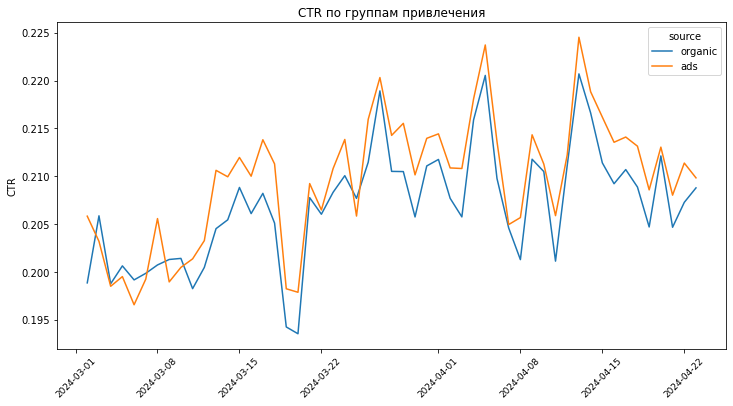

In [50]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='day', y='ctr', hue='source')
plt.title('CTR по группам привлечения')
plt.xticks(rotation=45, fontsize=9)
plt.xlabel('')
plt.ylabel('CTR')
plt.show()

### Выводы

1. Общее количество пользователей по каналам привлечения приблизительно одинаковое, но это связано с тем, что в период проведения рекламной акции 11 апреля был наплыв пользователей с канала `ads`. В целом по когортам в основном количество пользователей `organic`выше, чем `ads`.

2. На тепловых картах Retention хорошо заметно, что метрика для `organic` выше, чем для `ads`. Это говорит о том, что пользователям, привлеченным через платный трафик может быть не интересно наше приложение и нужно разбираться в причинах низкого показателя удержания пользователей. Особенно низкий Retention в когорте 11 апреля - только очень небольшой процент привлеченных рекламной акцией пользователей остались с нами. Это хорошо видно на диаграммах Retention по дням.

3. Однако, поюзерный CTR у пользователей `ads`как будто бы выше, чем у `organic` на протяжении практически всего времени работы приложения (некоторые падения показателя относительно `organic` заметны до 10 марта).

В целом можно сделать вывод, что необходимо разбираться с причинами низкого показателя удержания для `ads`, при этом в высоких относительно `organic` показателях CTR есть потенциал для поиска возможных решений.